<a href="https://www.kaggle.com/code/inapark/221225?scriptVersionId=115299386" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import os, sys
import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Dict
from matplotlib.ticker import PercentFormatter

# Contents

* [<font size=4>1. Read Data</font>](#1)
    
* [<font size=4>2. Articles</font>](#2)
    * [2.1 What product do they have the most?](#2.1)
    * [2.2 Pareto Analysis](#2.2)
    * [2.3 What type of index that is accounted for the most?](#2.3)
    * [2.4 what's the portion of index group name for each garment group?](#2.4)
    

* [<font size=4>3. Customer</font>](#3)
    * [3.1 How many Customers for each of club member status?](#3.1)
    * [3.2 How many customers receive the fashion news by frequency?](#3.2)
    * [3.3 How old customers overall?](#3.3)
    * [3.4 How many customers for each of club member status](#3.4)
    * [3.5 Correlation : age & club member status](#3.5)
    * [3.6 Correlation : age & fashion news frequency](#3.6)
    
    
* [<font size=4>4. Transactions</font>](#4)
    * [4.1 Price Distribution](#4.1)
    * [4.2 Which products do they buy the most?](#4.2)
    * [4.3 How's the mean price for each product by index_name](#4.3)


* [<font size=4>5. Image</font>](#5)

# <center><font size=6><a id=1>1. Read Data</a><font><center>

In [2]:
# image = "../input/h-and-m-personalized-fashion-recommendations/images"
articles = "../input/h-and-m-personalized-fashion-recommendations/articles.csv"
customers = "../input/h-and-m-personalized-fashion-recommendations/customers.csv"
transactions = "../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv"

# <center><font size=6><a id=2>2. Articles</a></font></center>

In [3]:
def create_df(url:str) -> pd.DataFrame:
    df = pd.read_csv(url)
    return df

def get_article_id(df:pd.DataFrame, ids:pd.Series) -> pd.DataFrame:
    df['article_id'] = ["0" + str(id) for id in ids]
    return df

In [4]:
articles = create_df(articles)
ids = articles['article_id']
articles = get_article_id(articles, ids)

# 2.1 What product do they have the most?<a id=2.1></a>

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def val_cnt(df:pd.DataFrame, col:str, top_n:int):
    plt.figure(figsize = (8, 6))
    sns.set(style = 'whitegrid')
    _order = df[col].value_counts()[:top_n].index
    viz = sns.countplot(x = col, data = df,
                        order = _order)
    plt.xticks(rotation = 45)
    plt.show()

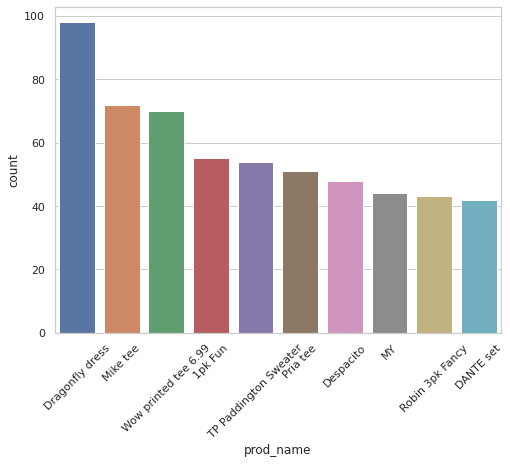

In [6]:
val_cnt(articles, 'prod_name', 10)

Since they have many products, I filtered out the ‘Top10’ products. As a result, they have almost 100 ‘Dragonfly dress’ while the ‘DANTE set’ is the product they carry the least amount of. Make sure to know that the product they have the most of doesn’t necessarily mean that product is the most popular. We don’t know exactly why they have products the most.

# 2.2 Pareto Analysis<a id=2.2></a>

In [7]:
def create_dict(lst_1:list, lst_2:list) -> dict:
    res = dict(zip(lst_1, lst_2))
    return res

def id_name_price(id_prod_name_dict:Dict[str,str], id_price_dict:Dict[str, int]):
    
    set_1 = set(id_prod_name_dict)
    set_2 = set(id_price_dict)
    shared_id = set_1.intersection(set_2)
    
    res_lst = []
    for _id in id_price_dict:
        if _id in shared_id:
            res_prod_name = id_prod_name_dict[_id]
            res_price = id_price_dict[_id]
            res_lst.append([_id, res_prod_name, res_price])
    return res_lst

In [8]:
df1 = articles[['article_id', 'prod_name']]
lst_1 = [_id for _id in articles['article_id']]
lst_2 = [name for name in articles['prod_name']]
id_name_dict = create_dict(lst_1, lst_2)

# to_dict()

In [9]:
transactions = create_df(transactions)
ids = transactions['article_id']
transactions = get_article_id(transactions, ids)

df2 = transactions[['article_id', 'price']]
t_article_ids = [_id for _id in transactions['article_id']]
t_prices = [price for price in transactions['price']]
id_price_dict = create_dict(t_article_ids, t_prices)

In [10]:
res_lst = id_name_price(id_name_dict, id_price_dict)

In [11]:
ids = [lst[0] for lst in res_lst]
prod_names = [lst[1] for lst in res_lst]
prices = [lst[2] for lst in res_lst]

In [12]:
final = pd.DataFrame({'article_id' : ids,
                    'product_name' : prod_names,
                    'product_price' : prices})
final.head()

,article_id,product_name,product_price
0,0663713001,Atlanta Push Body Harlow,0.022017
1,0541518023,Rae Push (Melbourne) 2p,0.011847
2,0505221004,Inca Jumper,0.015237
3,0685687003,W YODA KNIT OL OFFER,0.011780
4,0685687004,W YODA KNIT OL OFFER,0.015237


In [13]:
# pareto chart - 1 : number of purchase

def df_for_pareto_chart(agg_df:pd.DataFrame, col:str) -> pd.DataFrame:    
    agg_df['cum_value'] = (agg_df[col].cumsum() / agg_df[col].sum()) * 100
    return agg_df

def pareto_chart_viz(df:pd.DataFrame, tar_col:str, left_y_axis:str, right_y_asix:str):
    
    color1 = 'steelblue'
    color2 = 'red'
    line_size = 5

    fig, ax = plt.subplots()
    ax.bar(df[tar_col],df[left_y_axis], color = color1)
    fig.autofmt_xdate(rotation = 45)

    ax2 = ax.twinx()
    ax2.plot(df[tar_col], df[right_y_asix], color = color2, marker = "D", ms = line_size)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis = 'y', colors = color1)
    ax.tick_params(axis = 'y', colors = color2)

    plt.show()

In [14]:
agg_df = final.groupby('product_name')['product_name'].count().reset_index(name = 'num_of_purchase')
agg_df = agg_df.sort_values(by = 'num_of_purchase', ascending = False)[:10]
df = df_for_pareto_chart(agg_df, 'num_of_purchase')

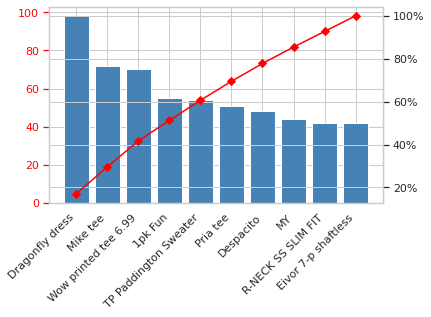

In [15]:
pareto_chart_viz(df, 'product_name', 'num_of_purchase', 'cum_value')

Pareto analysis is that 80% of consequences comes from 20% of causes. Then how apply this method to my project. First I figured out which product did customers purchase. I filtered out top10 products. Then I calculated the cumulative number of purchase to create pareto chart.

Interpretation : Over 80& of all the number of purchase are from the first 7 products. That means we need to order these products more than any other products.

In [ ]:
# pareto chart 2 - price

agg_df_2 = final.groupby('product_name')['product_price'].sum().reset_index(name = 'sum_price')
agg_df_2 = agg_df_2.sort_values(by = 'sum_price', ascending = False)[:10]
df_2 = df_for_pareto_chart(agg_df_2, 'sum_price')

In [ ]:
pareto_chart_viz(df_2, 'product_name', 'sum_price', 'cum_value')

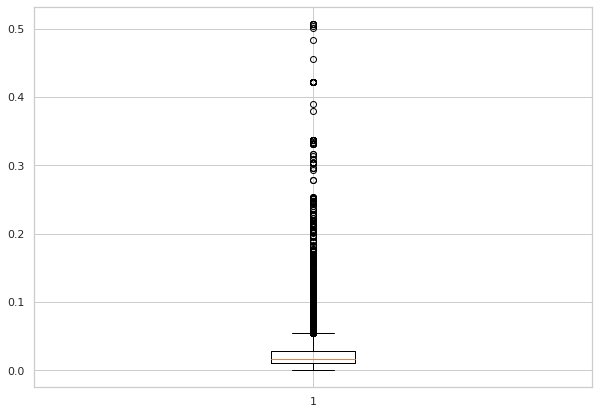

In [25]:
# univariate analysis : Price
data = final['product_price'].tolist()
fig = plt.figure(figsize =(10, 7))
plt.boxplot(data)
plt.show()

interpretation
- max : almost 0.6
- min : 0.0
- median : 0.03
- interquartile range : 0.03 - 0.01 = 0.02

# 2.3 What type of index that is accounted for the most?<a id=2.3></a>

In [6]:
def pie_chart(df:pd.DataFrame, col:str):
    _cnt_of_col = df[col].value_counts()
    _name_cnt = [tuple((x, y)) for x, y in _cnt_of_col.items()]
    _vals = [val[1] for val in _name_cnt]
    _label = [val[0] for val in _name_cnt]
    plt.pie(_vals, labels = _label,
            radius = 1.5, autopct = "%0.2f%%")
    plt.show()

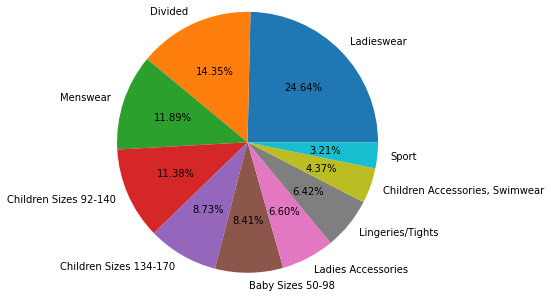

In [7]:
pie_chart(articles, 'index_name')

In this dataset, H&M tracks a hierarchy of its products. It seems that the index name is the main category which implies the “sub-categories”, or “index group names”. I’d like to look at this whole pie chart to visualize how the it’s separated by index name.

It is clear that ‘Ladieswear’ is the largest portion of the index, whereas the ‘Sport’ is undoubtedly the smallest. It is also clear that ‘Ladieswear’ is twice as large a portion as ‘Menswear’.

# 2.4 what's the portion of index group name for each garment group?<a id=2.4></a>

In [ ]:
def portion(df:pd.DataFrame, y:str, hue:str):
    _f, _ax = plt.subplots(figsize = (10, 10))
    _ax = sns.histplot(data=df, y=y, hue=hue, multiple="stack")
    plt.show()

In [ ]:
portion(articles, 'garment_group_name', 'index_group_name')

As you can see each of garment group has different portion of product index group. You would guess most garment groups have a large portion of Ladieswear. It’s quite obvious that you identified the fact that Ladieswear has the largest portion of the product index.

# <center><font size=6><a id=3>3. Customer</a></font></center>

In [ ]:
customers = create_df(customers)
customers.head()

# 3.1 How many Customers for each of club member status?(percentage)<a id=3.1></a>

In [ ]:
def cust_ratio(df:pd.DataFrame, col:str, check_val:str) -> float: 
    _total = df.shape[0]
    _target = df[df[col] == check_val].shape[0]
    return round((_target/_total) * 100, 2)

In [ ]:
cust_ratio(customers, 'club_member_status', 'ACTIVE')

In this step, you would know what percentage for each of club member status. For example, 'ACTIVE' status in club member status is almost 93%.  

# 3.2 How many customers receive the fashion news by frequency?<a id=3.2></a>

In [ ]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('None', 'NONE')

In [ ]:
def pie_chart(df:pd.DataFrame, col:str):
    _cnt_of_col = df[col].value_counts()
    _colname_cnt = [tuple((x, y)) for x, y in _cnt_of_col.items()]
    
    _cnt_no_response = df[col].isna().sum()
    tuple_val = tuple(('No Response', _cnt_no_response))
    _colname_cnt.append(tuple_val)

    _vals = [val[1] for val in _colname_cnt]
    _labels = [val[0] for val in _colname_cnt]
    
    plt.pie(_vals, labels = _labels, radius = 1.5, autopct = "%0.2f%%")
    plt.show()

In [ ]:
pie_chart(customers, 'fashion_news_frequency')

In this step, I needed to handle the 'fashion_news_frequency' because they have some vague value that may be confusing. It originally had 'None' and 'none' value simultaneously. The 'none' value is supposed to be same value of 'None' so that I replace the 'none' with 'NONE'. The other possible error that you may encountered is that they have 'Nan' value to handle. I normally ignore the 'Nan' value, but this time I decided to keep this because it is possible that some customers didn't answer the question even though they receive the news letter frequently. With that reason, I converted the 'Nan' value into 'No response' in case they missed the chance to answer.

# 3.3 How old customers overall?<a id=3.3></a>

In [ ]:
customers = customers.dropna(axis = 0)

In [ ]:
def distribution(df:pd.DataFrame, col:str):
    df[col] = df[col].astype(int)
    df[col].plot.hist()
    plt.show()

In [ ]:
distribution(customers, 'age')

The chart shows hte age distribution. Most of people are 20's and 30's age. 

# 3.4 How many customers for each of club member status(chart)<a id=3.4></a>

In [ ]:
# univariate analysis

def bar_plot_for_club_member_status(status : List[str], number_of_customers : List[int]):
    fig = plt.figure(figsize = (10, 5))
    plt.bar(status, number_of_customers)

In [ ]:
data = customers['club_member_status'].value_counts()
status = list(data.index)
number_of_customers = list(data.values)

# 3.5 Correlation : age & club member status<a id=3.5></a>

In this step, I wanted to figure out how customer age affects club member status. I assumed that the more they're young, the more they're likely to subscribe club member status. For that I did correlation analysis.

Correlation show the proportionality of two data sets. Simply, I could say y = mx + b. A positive correlation exists between variables 'x' and 'y' if 'm' is a positive value and an increase in 'x' results in an increase in 'y'. Conversely, if two variables have a negative correlation, 'm' will be a negative value, and 'y' will decrease as 'x' increases.

For me, variable 'x' means 'age' and the other variable is 'number of club member status'

In [ ]:
num_status_by_age = customers.groupby(['club_member_status'])['age'].value_counts().reset_index(name = 'number of status')

In [ ]:
active = num_status_by_age[num_status_by_age['club_member_status'] == 'ACTIVE']

In [ ]:
age = active['age'].tolist()
num_of_cust = active['number of status'].tolist()

corr, _ = stats.pearsonr (age, num_of_cust)
corr

In [ ]:
sns.heatmap(active.corr(), vmin = -1, vmax = 1, annot = True, cmap = "rocket_r")
plt.show()

You may be confused about how to interpret the result of correlation. There's no clear-cut threshold to determine whether data sets are correlated or not. While there's a lot of opinion on this, I used the threshold that is down below.

- -1 to -0.7 : Strong negative correlation
- -0.7 to -0.5 : Negative correlation
- -0.5 to 0.5 : No correlation
- 0.5 to 0.7 : Positive correlation
- 0.7 to 1 : Strong positive correlation

We got -0.79 correlation score of previous analysis. That means age and number of club member status have a strong negative correlation, which means as you get older, you're not likely to joing the club member.

# 3.6 Correlation : age & fashion news frequency<a id=3.6></a>

In [ ]:
age_and_frequency = customers[['age', 'fashion_news_frequency']]

In [ ]:
age_and_frequency.dropna(axis = 0, subset = ['age'], inplace = True)

In [ ]:
age_and_frequency.fillna('No Response', inplace = True)

In [ ]:
age_and_frequency['fashion_news_frequency'] = age_and_frequency['fashion_news_frequency'].replace('NONE', 'None')

In [ ]:
age_and_frequency = age_and_frequency.groupby(['age'])['fashion_news_frequency'].value_counts().reset_index(name = 'frequency_status')

In [ ]:
age_and_frequency[age_and_frequency['fashion_news_frequency'] == 'Regularly'].corr()

Similarly, I calculated the correlation between age and fashion news frequency. I guess that younger people are more subscribe fashion news regularly than the older people. As I assumed, the correlation score is almost -0.8, meaning that as the customer is younger they tend to subscribe the fashion news regularly.

# <center><font size=6><a id=4>4. Transaction</a><font><center>

In [ ]:
# transactions = create_df(transactions)
transactions

# 4.1 Price Distribution<a id=4.1></a>

In [ ]:
def price_distribution(df:pd.DataFrame, col:str):
    df[col].plot.hist()
    plt.show()

In [ ]:
price_distribution(transactions, 'price')

# 4.2 Which products do they buy the most?<a id=4.2></a>

In [ ]:
def loyal_cust(df:pd.DataFrame, col:str, top_n:int):
    top_n_cust = df[col].value_counts()[:top_n]
    return top_n_cust

In [ ]:
loyal_cust(transactions, 'article_id', 10)

We can basically answer to the question by counting each of article_id that is represented the unique product id. The product id ‘706016001’ is the most popular.

# 4.3 How's the mean price for each product by index_name?<a id=4.3></a>

In [ ]:
articles_df = articles[['article_id','index_name', 'product_group_name']]

In [ ]:
transactions_df = transactions[['article_id', 'price']]
ids = transactions_df['article_id']
transactions_df = get_article_id(transactions_df, ids)

In [ ]:
merge_df = transactions_df.merge(articles_df, on='article_id')
merge_df.head()

In [ ]:
def mean_price(df:pd.DataFrame, groupby_col:str):
    
    res = df.groupby(groupby_col)['price'].mean().reset_index()
    res = res.sort_values(by = 'price', ascending = False)

    sns.set_style('darkgrid')
    f,ax = plt.subplots(figsize = (10, 5))
    ax = sns.barplot(x = res.price, y = res.index_name, color = 'pink', alpha = 0.8)
    plt.show()

In [ ]:
mean_price(merge_df, 'index_name')

It can be seen that the mean price of Ladies wear is the highest that is over 0.03. Compared to this, the lowest mean price is Baby size clothes which is between 0.015 and 0.020.

# <center><font size=6><a id=5>5. Image</a><font><center>

In [ ]:
path = '../input/h-and-m-personalized-fashion-recommendations/images'

f_lst = []
for filename in os.listdir(path):
    res = os.path.join(path, filename)
    for file in os.listdir(res):
        f_lst.append(file)

for article_id in articles['article_id']:
    folder = article_id[:3]
    img = f'{article_id}.jpg'
    if img in f_lst:
        path = f'../input/h-and-m-personalized-fashion-recommendations/images/{folder}/{img}'
        res = Image.open(path)
        plt.imshow(res)
        break